In [18]:
import yaml
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import os
import seaborn as sns
from datetime import datetime
from scipy.stats import pearsonr
import numpy as np
import math

In [52]:
# Load the YAML file
yaml_file_path = Path("/workspace/data/lchu/hls/jobs/zero_shot_visualization_visualization.yaml")  # Replace with the actual path to your YAML file
with open(yaml_file_path, "r") as file:
    yaml_data = yaml.safe_load(file)
training_length = yaml_data["training_length"]
# Access the file path from the YAML data
data_file_path = Path(yaml_data["csv_dir"]) / "chip_stats.csv"
val_cloud_path = Path("/workspace/data/lchu/hls/logs/csv/3200-fair-bs16-2023-08-21_16-49-23/val_cloud_catalog.csv")
save_dir = Path(yaml_data["visualization_dir"])
os.makedirs(save_dir, exist_ok=True)

# Read the .txt file as a CSV using pandas
data_table = pd.read_csv(data_file_path)
val_clouds = pd.read_csv(val_cloud_path)
val_clouds.sort_values(by='fmask_name', inplace=True)

# Display the DataFrame
print(data_table.head())
print(val_clouds.head())

df = pd.concat([data_table.reset_index(drop=True), val_clouds.reset_index(drop=True)], axis=1)
print(df.columns)

        chip_id      chip_x     chip_y   tile  valid_first  valid_second  \
0  chip_002_060 -122.633558  48.932491  10UEV      49903.0       44547.0   
1  chip_021_109 -117.915818  48.565491  11UMP      50094.0       50165.0   
2  chip_026_164 -112.957171  48.949134  12UUV      50176.0       50175.0   
3  chip_027_083 -120.048482  47.830456  10UGU      49294.0       50118.0   
4  chip_031_077 -120.474559  47.502665  10TFT      50167.0       50162.0   

   valid_third  bad_pct_first  bad_pct_second  bad_pct_third  ...   B04 MAE  \
0      49313.0       0.213249        2.841996       0.998485  ...  0.007880   
1      50165.0       0.047832        0.011958       0.009965  ...  0.017966   
2      50176.0       0.000000        0.001993       0.000000  ...  0.007314   
3      49757.0       0.739397        0.033881       0.197305  ...  0.014785   
4      50163.0       0.011958        0.023916       0.023916  ...  0.009608   

    B05 MAE   B07 MAE   B08 MAE  B02 SSIM  B03 SSIM  B04 SSIM  B05 S

In [53]:
df['first_image_date'] = pd.to_datetime(df['first_image_date'])
df['second_image_date'] = pd.to_datetime(df['second_image_date'])
df['third_image_date'] = pd.to_datetime(df['third_image_date'])


# Calculate the difference in days
df['Time Gap'] = (df['third_image_date'] - df['first_image_date']).dt.days
df['Cloud Ratio'] = df['cloud_pct']
df['Overall RMSE'] = np.sqrt(df['Overall MSE'])
df['SSIM Error'] = (1 - df['Overall SSIM']) / df['Cloud Ratio']
print(df.head())
print(df.columns)

        chip_id      chip_x     chip_y   tile  valid_first  valid_second  \
0  chip_002_060 -122.633558  48.932491  10UEV      49903.0       44547.0   
1  chip_021_109 -117.915818  48.565491  11UMP      50094.0       50165.0   
2  chip_026_164 -112.957171  48.949134  12UUV      50176.0       50175.0   
3  chip_027_083 -120.048482  47.830456  10UGU      49294.0       50118.0   
4  chip_031_077 -120.474559  47.502665  10TFT      50167.0       50162.0   

   valid_third  bad_pct_first  bad_pct_second  bad_pct_third  ...  B07 SSIM  \
0      49313.0       0.213249        2.841996       0.998485  ...  0.963582   
1      50165.0       0.047832        0.011958       0.009965  ...  0.796521   
2      50176.0       0.000000        0.001993       0.000000  ...  0.978009   
3      49757.0       0.739397        0.033881       0.197305  ...  0.817672   
4      50163.0       0.011958        0.023916       0.023916  ...  0.944179   

   B08 SSIM                fmask_name  cloud_pct     usage      bin 

In [54]:
columns_to_average = [
    'B02 MSE', 'B03 MSE', 'B04 MSE', 'B05 MSE',
    'B07 MSE', 'B08 MSE', 'B02 MAE', 'B03 MAE',
    'B04 MAE', 'B05 MAE', 'B07 MAE', 'B08 MAE',
    'B02 SSIM', 'B03 SSIM', 'B04 SSIM', 'B05 SSIM',
    'B07 SSIM', 'B08 SSIM'
]
mae_list = ['B02 MAE', 'B03 MAE',
    'B04 MAE', 'B05 MAE', 'B07 MAE', 'B08 MAE']
mae_averages = df[mae_list].mean()
means = [mean / 10000 for mean in [495.7316,  814.1386,  924.5740, 2962.5623, 2640.8833, 1740.3031]]
error = mae_averages / means
print(error)
# Calculate column averages
column_averages = df[columns_to_average].mean()

# Print the calculated averages
print(column_averages)

B02 MAE    0.196672
B03 MAE    0.143774
B04 MAE    0.212742
B05 MAE    0.130900
B07 MAE    0.119534
B08 MAE    0.175513
dtype: float64
B02 MSE     0.000289
B03 MSE     0.000447
B04 MSE     0.001145
B05 MSE     0.004099
B07 MSE     0.002979
B08 MSE     0.003002
B02 MAE     0.009750
B03 MAE     0.011705
B04 MAE     0.019670
B05 MAE     0.038780
B07 MAE     0.031568
B08 MAE     0.030545
B02 SSIM    0.935625
B03 SSIM    0.939532
B04 SSIM    0.885795
B05 SSIM    0.841072
B07 SSIM    0.882871
B08 SSIM    0.867732
dtype: float64


             Overall SSIM Overall MAE Cloud Ratio  Time Gap
Overall SSIM       1.0***    -0.88***    -0.85***  -0.13***
Overall MAE      -0.88***      1.0***     0.69***   0.31***
Cloud Ratio      -0.85***     0.69***      1.0***     -0.02
Time Gap         -0.13***     0.31***       -0.02    1.0***
              Overall SSIM  Overall MAE  Cloud Ratio  Time Gap
Overall SSIM      1.000000    -0.876145    -0.848138 -0.127064
Overall MAE      -0.876145     1.000000     0.686677  0.313343
Cloud Ratio      -0.848138     0.686677     1.000000 -0.017933
Time Gap         -0.127064     0.313343    -0.017933  1.000000


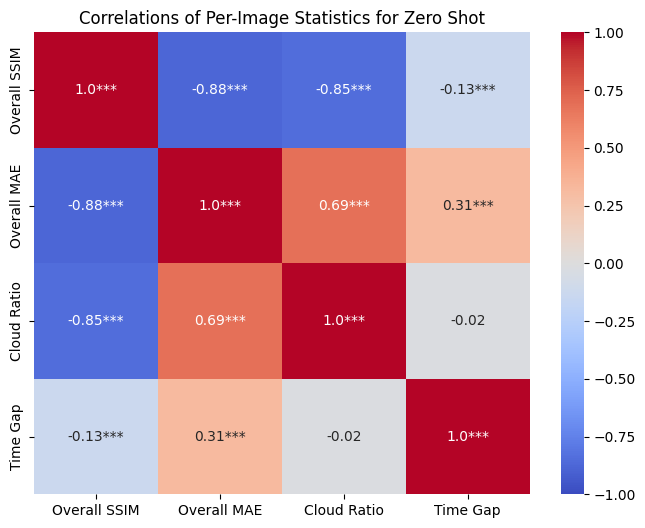

In [57]:
df = df[['Overall SSIM', 'Overall MAE',
       'Cloud Ratio', 'Time Gap']]


rho = df.corr()
pval = df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
significant_correlations = rho.round(2).astype(str) + p
print(significant_correlations)
print(rho)



# Create the heatmap of p-values
plt.figure(figsize=(8, 6))
sns.heatmap(rho, annot=significant_correlations, fmt='', cmap="coolwarm", vmin=-1, vmax=1)  # Format to 3 decimal places
plt.title(f'Correlations of Per-Image Statistics for ViT Fine-Tuning on {training_length}')

plt.savefig(save_dir / 'per_image_correlations.png', format='png')

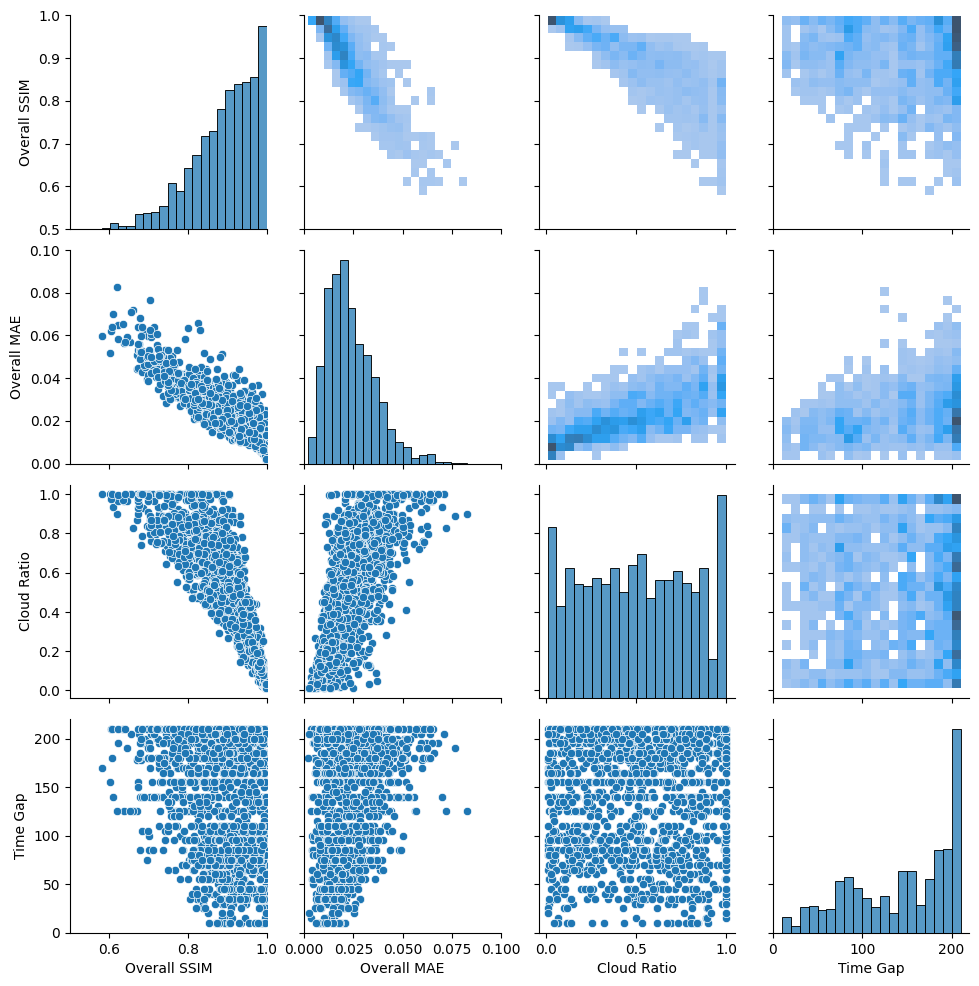

In [56]:
df = df[['Overall SSIM', 'Overall MAE', 'Cloud Ratio', 'Time Gap']]
g = sns.PairGrid(df, diag_sharey=False)

g.map_upper(sns.histplot, bins=20)
g.map_lower(sns.scatterplot)
g.map_diag(sns.histplot, bins=20)

g.axes[0,0].set_xlim(0.5,1)
g.axes[0,0].set_ylim(0.5,1)
g.axes[1,1].set_xlim(0,0.1)
g.axes[1,1].set_ylim(0,0.1)


plt.savefig(save_dir / 'per_image_pairgrid.png', format='png')